# MNIST

In this tutorial, we will show you how to train an actual CNN model, albeit small. We will be using the good ol' MNIST dataset and the LeNet model, with a slight change that the sigmoid activations are replaced with ReLUs.

We will use the model helper - that helps us to deal with parameter initializations naturally.

First, let's import the necessities.

In [ ]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil


from caffe2.python import core, model_helper, net_drawer, workspace, visualize, brew

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

We will track statistics during the training time and store these on disk in a local folder. We need to set up a data folder for the data and a root folder for the stats. You should already have these folders, and in the data folder the MNIST dataset should be setup as a lmdb database for both the training set and the test set for this tutorial. 

In [ ]:
# This section preps your image and test set in a lmdb database
def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile, StringIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")
    
    
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Look for existing database: lmdb
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True
    
if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    print("lmdb test db found!")
else:
    db_missing = True

# attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

if os.path.exists(root_folder):
    print("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)
    
os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

print("training data folder:" + data_folder)
print("workspace root folder:" + root_folder)

> If the database wasn't found in the last step, [download the MNIST lmdb database](https://download.caffe2.ai/databases/mnist-lmdb.zip) or review the [datasets and databases notebook](https://github.com/caffe2/caffe2/blob/master/caffe2/python/tutorials/MNIST_Dataset_and_Databases.ipynb) on how to create the database from the MNIST dataset.

We will be using the `ModelHelper` class to represent our main model and using `brew` module and `Operators` to build our model. `brew` module has a set of wrapper functions that automatically separates the parameter intialization and the actual computation into two networks. Under the hood, a `ModelHelper` object has two underlying nets, `param_init_net` and `net`, that keeps record of the initialization network and the main network respectively.

For the sake of modularity, we will separate the model to multiple different parts:

    (1) The data input part (AddInput function)
    (2) The main computation part (AddLeNetModel function)
    (3) The training part - adding gradient operators, update, etc. (AddTrainingOperators function)
    (4) The bookkeeping part, where we just print out statistics for inspection. (AddBookkeepingOperators function)
    
`AddInput` will load the data from a DB. We store MNIST data in pixel values, so after batching this will give us data with shape `(batch_size, num_channels, width, height)`, in this case `[batch_size, 1, 28, 28]` of data type *uint8* and a label with shape `[batch_size]` of data type *int*.
    
Since we are going to do float computations, we will cast the data to the *float* data type.
For better numerical stability, instead of representing data in [0, 255] range, we will scale them down to [0, 1].
Note that we are doing in-place computation for this operator: we don't need the pre-scale data.
Now, when computing the backward pass, we will not need the gradient computation for the backward pass. `StopGradient` does exactly that: in the forward pass it does nothing and in the backward pass all it does is to tell the gradient generator "the gradient does not need to pass through me".
    

In [4]:
def AddInput(model, batch_size, db, db_type):
    # load the data
    data_uint8, label = model.TensorProtosDBInput(
        [], ["data_uint8", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

At this point we need to take a look at the predictions coming out of the network at convert them into probabilities.
"What's the probability that this number we're looking at is a 5", or "is this a 7", and so forth. 

The results will be conformed into a range between 0 and 1 such that the closer you are to 1 the more likely the number matches the prediction. The process that we can use to do this is available in LeNet and will provide us the *softmax* prediction. The `AddLeNetModel` function below will output the `softmax`. However, in this case, it does much more than the softmax - it is the computed model with its convoluted layers, as well as the softmax.

[An explanation of kernels in image processing](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29) might be useful for more info on why `kernel=5` is used in the convolutional layers below. `dim_in` is the number of input channels and `dim_out` is the number of output channels. 

As you can see below `conv1` has 1 channel coming in (`dim_in`) and 20 going out (`dim_out`), whereas `conv2` has 20 going in and 50 going out and `fc3` has 50 going in and 500 going out. The images are transformed to smaller sizes along each convolution.d

TODO: include image of the model below

In [5]:
def AddLeNetModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    fc3 = brew.relu(model, fc3, fc3)
    pred = brew.fc(model, fc3, 'pred', 500, 10)
    softmax = brew.softmax(model, pred, 'softmax')
    return softmax

The `AddAccuracy` function below adds an accuracy operator to the model. We will use this in the next function to keep track of the model's accuracy.

In [6]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

The next function, `AddTrainingOperators`, adds training operators to the model. 

In the first step, we apply an Operator, `LabelCrossEntropy`, that computes the cross entropy between the input and the label set. This operator is almost always used after getting a softmax and before computing the model's loss. It's going to take in the `[softmax, label]` array along with a label, `'xent'` for "Cross Entropy".

    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    
`AveragedLoss` will take in the cross entropy and return the average of the losses found in the cross entropy.

    loss = model.AveragedLoss(xent, "loss")

For bookkeeping purposes, we will also compute the accuracy of the model by invoking the AddAccuracy function like so:

    AddAccuracy(model, softmax, label)

The next line is the key part of the training model: we add all the gradient operators to the model. The gradient is computed with respect to the loss that we computed above.

    model.AddGradientOperators([loss])
    

The next handful of lines support a very simple stochastic gradient descent. 
--- TODO(jiayq): We are working on wrapping these SGD operations in a cleaner fashion, and we will update this when it is ready. For now, you can see how we basically express the SGD algorithms with basic operators. 
It isn't necessary to fully understand this part at the moment, but we'll walk you through the process anyway.

`Iter` operator is a counter for the number of iterations we run in the training. We use `brew.iter` helper function to add it to model

    ITER = brew.iter(model, "iter")

We do a simple learning rate schedule where lr = base_lr * (t ^ gamma)
Note that we are doing minimization, so the base_lr is negative so we are going the DOWNHILL direction. 

    LR = model.LearningRate(
        ITER, "LR", base_lr=-0.1, policy="step", stepsize=1, gamma=0.999 )
ONE is a constant value that is used in the gradient update. We only need to create it once, so it is explicitly placed in param_init_net.

    ONE = model.param_init_net.ConstantFill([], "ONE", shape=[1], value=1.0)

Now, for each parameter, we do the gradient updates. Note how we get the gradient of each parameter - `ModelHelper` keeps track of that. The update is a simple weighted sum: param = param + param_grad * LR

    for param in model.params:
        param_grad = model.param_to_grad[param]
        model.WeightedSum([param, ONE, param_grad, LR], param)        
        
We will need to checkpoint the parameters of the model periodically. This is achieved via the Checkpoint operator. It also takes in a parameter "every" so that we don't checkpoint way too often. In this case, we will say let's checkpoint every 20 iterations, which should probably be fine.

    model.Checkpoint([ITER] + model.params, [],
                   db="mnist_lenet_checkpoint_%05d.lmdb",
                   db_type="lmdb", every=20)

In [7]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # do a simple stochastic gradient descent
    ITER = brew.iter(model, "iter")
    # set the learning rate schedule
    LR = model.LearningRate(
        ITER, "LR", base_lr=-0.1, policy="step", stepsize=1, gamma=0.999 )
    # ONE is a constant value that is used in the gradient update. We only need
    # to create it once, so it is explicitly placed in param_init_net.
    ONE = model.param_init_net.ConstantFill([], "ONE", shape=[1], value=1.0)
    # Now, for each parameter, we do the gradient updates.
    for param in model.params:
        # Note how we get the gradient of each parameter - ModelHelper keeps
        # track of that.
        param_grad = model.param_to_grad[param]
        # The update is a simple weighted sum: param = param + param_grad * LR
        model.WeightedSum([param, ONE, param_grad, LR], param)

The following function, `AddBookkeepingOperations`, adds a few bookkeeping operators that we can inspect later. These operators do not affect the training procedure: they only collect statistics and prints them to file or to logs.

In [8]:
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.

Now, let's actually create the models for training and testing. If you are seeing WARNING messages below, don't be alarmed. The functions we established earlier are now going to be executed. Remember the four steps that we're doing:

    (1) data input  
    (2) main computation
    (3) training 
    (4) bookkeeping
    
Before we can do the data input though we need to define our training model. We will basically need every piece of the components we defined above. In this example, we're using NCHW storage order on the mnist_train dataset. 

In [9]:
arg_scope = {"order": "NCHW"}
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
softmax = AddLeNetModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
AddBookkeepingOperators(train_model)

# Testing model. We will set the batch size to 100, so that the testing
# pass is 100 iterations (10,000 images in total).
# For the testing model, we need the data input part, the main LeNetModel
# part, and an accuracy part. Note that init_params is set False because
# we will be using the parameters obtained from the train model.
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddLeNetModel(test_model, data)
AddAccuracy(test_model, softmax, label)

# Deployment model. We simply need the main LeNetModel part.
deploy_model = model_helper.ModelHelper(
    name="mnist_deploy", arg_scope=arg_scope, init_params=False)
AddLeNetModel(deploy_model, "data")
# You may wonder what happens with the param_init_net part of the deploy_model.
# No, we will not use them, since during deployment time we will not randomly
# initialize the parameters, but load the parameters from the db.


BlobReference("softmax")

Now, let's take a look what the training and deploy models look like, using the simple graph visualization tool that Caffe2 has. If the following command fails for you, it might be because that the machine you run on does not have graphviz installed. You can usually install that by:

```sudo yum install graphviz```

If the graph looks too small, right click and open the image in a new tab for better inspection.

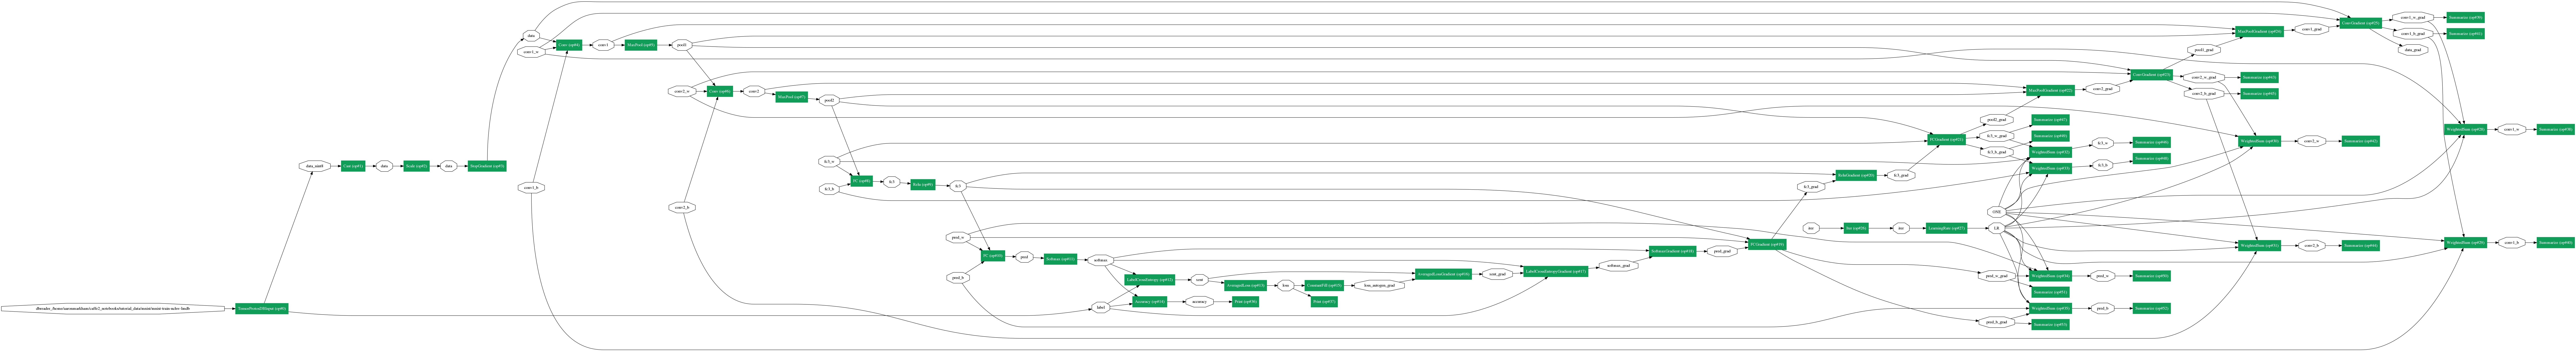

In [10]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

Now, the graph above shows everything that is happening in the training phase: the white nodes are the blobs, and the green rectangular nodes are the operators being run. You may have noticed the massive parallel lines like train tracks: these are dependencies from the blobs generated in the forward pass to their backward operators.

Let's display the graph in a more minimal way by showing only the necessary dependencies and only showing the operators. If you read carefully, you can see that the left half of the graph is the forward pass, the right half of the graph is the backward pass, and on the very right there are a set of parameter update and summarization operators.

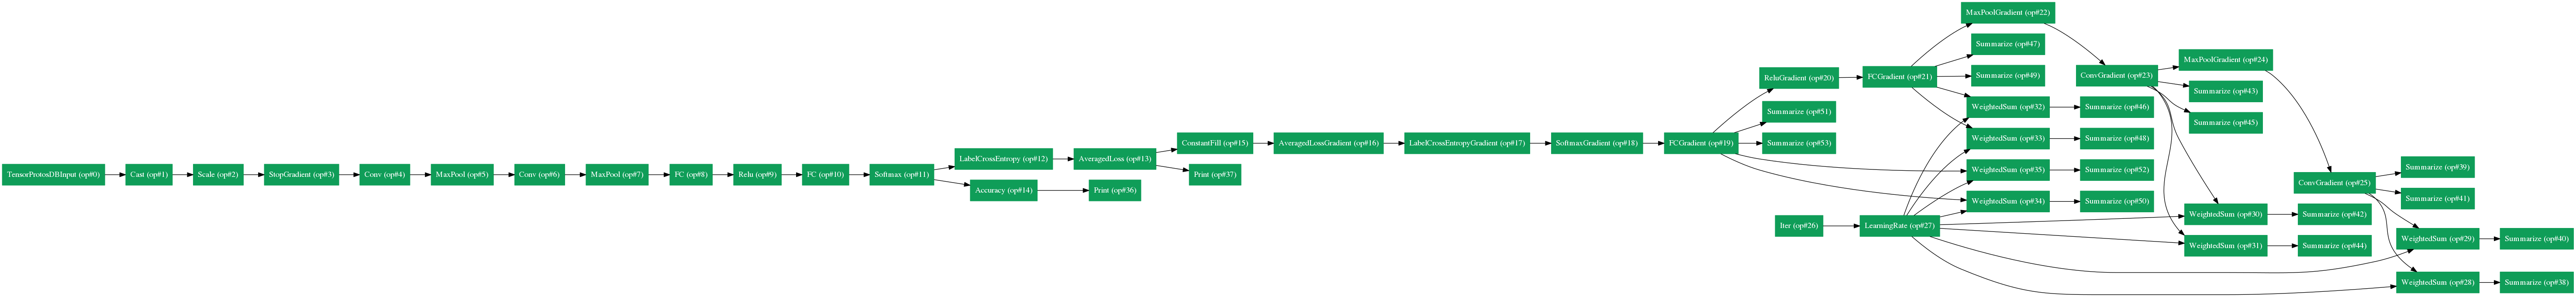

In [11]:
graph = net_drawer.GetPydotGraphMinimal(
    train_model.net.Proto().op, "mnist", rankdir="LR", minimal_dependency=True)
display.Image(graph.create_png(), width=800)

Now, when we run the network, one way is to directly run it from Python. Remember as we are running the network, we can periodically pull blobs from the network - Let's first show how we do this.

Before, that, let's re-iterate the fact that, the ModelHelper class has not executed anything yet. All it does is to *declare* the network, which is basically creating the protocol buffers. For example, we will show a portion of the serialized protocol buffer for the training models' param init net.

In [12]:
print(str(train_model.param_init_net.Proto())[:400] + '\n...')

name: "mnist_train_init"
op {
  output: "dbreader_/home/aaronmarkham/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "lmdb"
  }
  arg {
    name: "db"
    s: "/home/aaronmarkham/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  }
}
op {
  output: "conv1_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "sha
...


We will also dump all the protocol buffers to disk so you can easily inspect them. As you may have noticed, these protocol buffers are much like the old good caffe's network definitions.

In [13]:
with open(os.path.join(root_folder, "train_net.pbtxt"), 'w') as fid:
    fid.write(str(train_model.net.Proto()))
with open(os.path.join(root_folder, "train_init_net.pbtxt"), 'w') as fid:
    fid.write(str(train_model.param_init_net.Proto()))
with open(os.path.join(root_folder, "test_net.pbtxt"), 'w') as fid:
    fid.write(str(test_model.net.Proto()))
with open(os.path.join(root_folder, "test_init_net.pbtxt"), 'w') as fid:
    fid.write(str(test_model.param_init_net.Proto()))
with open(os.path.join(root_folder, "deploy_net.pbtxt"), 'w') as fid:
    fid.write(str(deploy_model.net.Proto()))
print("Protocol buffers files have been created in your root folder: " + root_folder)

Protocol buffers files have been created in your root folder: /home/aaronmarkham/caffe2_notebooks/tutorial_files/tutorial_mnist


Next we will run the training procedure. We will drive all the computation in Python here, however you can also write a plan out to disk so that you can completely train stuff in C++.  We'll leave discussion on that route for another tutorial.

Please note that this process will take a while to run. Keep an eye on the asterisk (In [\*]) or other IPython indicators that the code block is still running.

First we must initialize the network with:

    workspace.RunNetOnce(train_model.param_init_net)
    
Since we are going to run the main network multiple times, we first create the network which puts the actual network generated from the protobuf into the workspace.

    workspace.CreateNet(train_model.net)

We will set the number of iterations that we'll run the network to 200 and create two numpy arrays to record the accuracy and loss for each iteration.

    total_iters = 200
    accuracy = np.zeros(total_iters)
    loss = np.zeros(total_iters)

With the network and tracking of accuracy and loss setup we can now loop the 200 interations calling `workspace.RunNet` and passing the name of the network `train_model.net.Proto().name`. On each iteration we calculate the accuracy and loss with `workspace.FetchBlob('accuracy')` and `workspace.FetchBlob('loss')`.

    for i in range(total_iters):
        workspace.RunNet(train_model.net.Proto().name)
        accuracy[i] = workspace.FetchBlob('accuracy')
        loss[i] = workspace.FetchBlob('loss')

Finally, we can plot the results using `pyplot`.

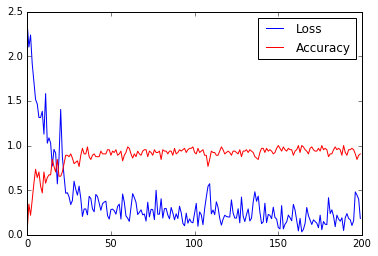

In [14]:
# The parameter initialization network only needs to be run once.
workspace.RunNetOnce(train_model.param_init_net)
# creating the network
workspace.CreateNet(train_model.net, overwrite=True)
# set the number of iterations and track the accuracy & loss
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.FetchBlob('accuracy')
    loss[i] = workspace.FetchBlob('loss')
# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

Now we can sample some of the data and predictions. 

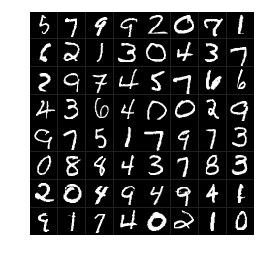

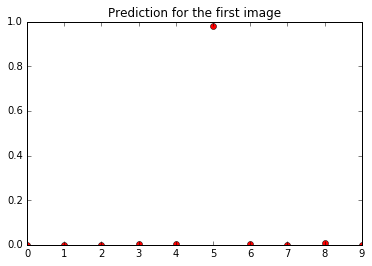

In [15]:
# Let's look at some of the data.
pyplot.figure()
data = workspace.FetchBlob('data')
_ = visualize.NCHW.ShowMultiple(data)
pyplot.figure()
softmax = workspace.FetchBlob('softmax')
_ = pyplot.plot(softmax[0], 'ro')
pyplot.title('Prediction for the first image')

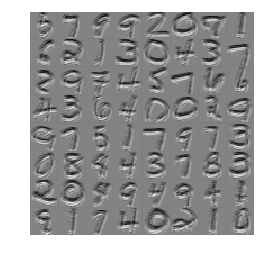

In [16]:
# Convolutions for this mini-batch
pyplot.figure()
conv = workspace.FetchBlob('conv1')
shape = list(conv.shape)
shape[1] = 1
# We can look into any channel. This of it as a feature model learned
conv = conv[:,15,:,:].reshape(shape)

_ = visualize.NCHW.ShowMultiple(conv)

Remember that we created the test net? We will run the test pass and report the test accuracy here. Note that although test_model will be using the parameters obtained from train_model, test_model.param_init_net must still be run to initialize the input data.
In this run, we only need to track the accuracy and we're also only going to run 100 iterations.

test_accuracy: 0.953800


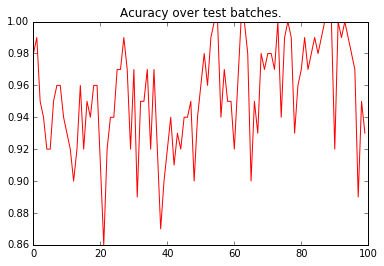

In [17]:
# run a test pass on the test net
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_accuracy = np.zeros(100)
for i in range(100):
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy[i] = workspace.FetchBlob('accuracy')
# After the execution is done, let's plot the values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Acuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

This concludes the MNIST tutorial. We hope this tutorial highlighted some of Caffe2's features and how easy it is to create a simple CNN.